In [1]:
%matplotlib inline
#  disable transparency for gif making
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import os
from glob import glob

import numpy as np
import pandas as pd
idx = pd.IndexSlice
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.ticker import MaxNLocator

import geopandas as gpd

from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

import contextily as cx

In [2]:
data_dir = '/cluster/tufts/hugheslab/datasets/NSF_OD/'
svi_dir = os.path.join(data_dir,'SocialVulnerabilityIndex')
result_dir = os.path.join(data_dir, 'results')
mass_shapefile = os.path.join(data_dir,'shapefiles','MA_2021')

In [3]:
svi_file = os.path.join(result_dir,'svi_qtr')
svi_gdf = gpd.read_file(svi_file)

In [4]:
svi_gdf = svi_gdf.rename(columns={'INTPTLAT':'lat', 'INTPTLON':'lon', 'GEOID':'grid_squar'})
# Make lat and lon floats
svi_gdf.loc[:, 'lat'] = svi_gdf.lat.astype(float)
svi_gdf.loc[:, 'lon'] = svi_gdf.lon.astype(float)
deaths_gdf = svi_gdf

just_grid = deaths_gdf.loc[(deaths_gdf['year']==2000)&(deaths_gdf['quarter']==4), ['grid_squar','geometry', 'lat', 'lon']]


In [5]:
deaths_gdf = deaths_gdf.fillna(deaths_gdf.mean())
deaths_gdf = deaths_gdf.drop_duplicates(['grid_squar','year','quarter','deaths'])

In [6]:
# Make lat and lon floats
deaths_gdf.loc[:, 'lat'] = deaths_gdf.lat.astype(float)
deaths_gdf.loc[:, 'lon'] = deaths_gdf.lon.astype(float)

In [7]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    https://stackoverflow.com/a/4913653/1748679
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r

In [16]:
# Calculate each squares neighbors
neighbors = {}
for _, row in just_grid.iterrows():
    just_grid.loc[:,'haversine'] = just_grid.apply(lambda x: haversine(row['lon'], row['lat'],
                                                                         x['lon'], x['lat']),
                                                  axis=1)
    matching_neighbors = just_grid[just_grid['haversine']<8]['grid_squar'].values
    neighbors[row['grid_squar']]=matching_neighbors

In [17]:
tracts = deaths_gdf['grid_squar'].unique()
min_year = deaths_gdf.year.min()
max_year = deaths_gdf.year.max()
deaths_gdf = deaths_gdf.set_index(['grid_squar','year','quarter']).sort_index()
deaths_gdf.loc[idx[:,:,:],'self_t-1'] = deaths_gdf.loc[idx[:,:,:],'deaths'].shift(1, fill_value=0)
deaths_gdf.loc[idx[:,:,:],'delta_deaths'] = deaths_gdf.loc[idx[:,:,:],'deaths'] - deaths_gdf.loc[idx[:,:,:],'self_t-1']
for tract in tracts:
     deaths_gdf.loc[idx[tract,:,:],'neighbor_t-1']= \
        deaths_gdf.loc[idx[neighbors[tract],:,:],'self_t-1'].groupby(level=['year', 'quarter']).mean().shift(1, fill_value=0).values

In [18]:
timestep = 0

for year in range(min_year, max_year+1):
    for quarter in range(1, 5):
        deaths_gdf.loc[idx[:,year, quarter], 'timestep'] = timestep
        timestep+=1

In [19]:
deaths_gdf_with_autoregressive = deaths_gdf.reset_index()

In [12]:
train_x_through_2018 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']<=2018][['grid_squar','lat', 'lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile', 'neighbor_t-1', 'self_t-1']]
train_y_through_2018 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']<=2018][['grid_squar','timestep','delta_deaths']]
train_x_through_2019 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']<=2019][['grid_squar','lat', 'lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile', 'neighbor_t-1', 'self_t-1']]
train_y_through_2019 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']<=2019][['grid_squar','timestep','delta_deaths']]

x_just_2019 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']==2019][['grid_squar','lat', 'lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile','neighbor_t-1', 'self_t-1']]
y_just_2019 = deaths_gdf_with_autoregressive[(deaths_gdf_with_autoregressive['year']==2019)&(deaths_gdf_with_autoregressive['quarter']==1)][['grid_squar','timestep','delta_deaths']]
x_just_2020 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']==2020][['grid_squar','lat', 'lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile', 'neighbor_t-1', 'self_t-1']]
y_just_2020 = deaths_gdf_with_autoregressive[(deaths_gdf_with_autoregressive['year']==2020)&(deaths_gdf_with_autoregressive['quarter']==1)][['grid_squar','timestep','delta_deaths']]

In [13]:
deaths_gdf

STATEFP COUNTYFP TRACTCE     NAME  \
grid_squar  year quarter                                     
25001010100 2000 1            25      001   10100      101   
                 2            25      001   10100      101   
                 3            25      001   10100      101   
                 4            25      001   10100      101   
            2001 1            25      001   10100      101   
...                          ...      ...     ...      ...   
25027761402 2020 4            25      027  761402  7614.02   
            2021 1            25      027  761402  7614.02   
                 2            25      027  761402  7614.02   
                 3            25      027  761402  7614.02   
                 4            25      027  761402  7614.02   

                                      NAMELSAD  MTFCC FUNCSTAT     ALAND  \
grid_squar  year quarter                                                   
25001010100 2000 1            Census Tract 101  G5020        S  25046216   
                 2            Census Tract 101  G5020        S  25046216   
                 3            Census Tract 101  G5020        S  25046216   
                 4            Census Tract 101  G5020        S  25046216   
            2001 1            Census Tract 101  G5020        S  25046216   
...                                        ...    ...      ...       ...   
25027761402 2020 4        Census Tract 7614.02  G5020        S  25568170   
            2021 1        Census Tract 7614.02  G5020        S  25568170   
                 2        Census Tract 7614.02  G5020        S  25568170   
                 3        Census Tract 7614.02  G5020        S  25568170   
                 4        Census Tract 7614.02  G5020        S  25568170   

                            AWATER        lat  ...  svi_pctile         FIPS  \
grid_squar  year quarter                       ...                            
25001010100 2000 1        12765872  42.059829  ...      0.6230  25001010100   
                 2        12765872  42.059829  ...      0.6230  25001010100   
                 3        12765872  42.059829  ...      0.6230  25001010100   
                 4        12765872  42.059829  ...      0.6230  25001010100   
            2001 1        12765872  42.059829  ...      0.6230  25001010100   
...                            ...        ...  ...         ...          ...   
25027761402 2020 4          209089  42.531342  ...      0.2237         None   
            2021 1          209089  42.531342  ...      0.2237         None   
                 2          209089  42.531342  ...      0.2237         None   
                 3          209089  42.531342  ...      0.2237         None   
                 4          209089  42.531342  ...      0.2237         None   

                          ROUNDED_TR  ROUNDED__1  TRACTCE_y  \
grid_squar  year quarter                                      
25001010100 2000 1              None        None       None   
                 2              None        None       None   
                 3              None        None       None   
                 4              None        None       None   
            2001 1              None        None       None   
...                              ...         ...        ...   
25027761402 2020 4            761400      761400       None   
            2021 1            761400      761400       None   
                 2            761400      761400       None   
                 3            761400      761400       None   
                 4            761400      761400       None   

                                                                   geometry  \
grid_squar  year quarter                                                      
25001010100 2000 1        POLYGON ((-70.25001 42.06410, -70.24959 42.065...   
                 2        POLYGON ((-70.25001 42.06410, -70.24959 42.065...   
                 3        POLYGON ((-70.25001 42.06410, -70.24959

In [29]:
min_deaths = 1000
max_deaths = -1000


for year in range(min_year, max_year+1):
    for qtr in range(1,5):
        fig, ax = plt.subplots(1, 1, figsize=(12,8))
        this_year = deaths_gdf.loc[idx[:,year,qtr], :]
        this_year.plot(column='deaths', cmap='magma',ax=ax, legend=True,
                      vmin=0, vmax=9)
        count = this_year.deaths.sum()
        this_min = this_year.deaths.min()
        this_max = this_year.deaths.max()
        
        if this_min < min_deaths:
            min_deaths = this_min
        if this_max > max_deaths:
            max_deaths = this_max
        plt.rcParams['axes.facecolor'] = 'w'
        plt.title(f'{year} Q{qtr}: {count:.0f} deaths')
        plt.savefig(os.path.join(result_dir,f'{year}_q{qtr}_deaths.png'))
        plt.close()

In [30]:
!ffmpeg -i /cluster/tufts/hugheslab/datasets/NSF_OD/results/2%*_q%*_deaths.png -vf  palettegen /cluster/tufts/hugheslab/datasets/NSF_OD/results/deaths_palette.png

ffmpeg version 5.0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 10.3.0 (conda-forge gcc 10.3.0-16)
  configuration: --prefix=/cluster/tufts/hugheslab/kheuto01/miniconda3/envs/zigp_36 --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1654044055843/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-demuxer=dash --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-vaapi --enable-libx264 --enable-libx265 --enable-libaom --enable-libsvtav1 --enable-libxml2 --enable-libvpx --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame --pkg-config=/home/conda/feedstock_root/build_artifacts/ffmpeg_1654044055843/_build_env/bin/pkg-config
  libavutil      57. 17.100 / 57. 17.100
  libavcodec     59. 18.100 / 59. 18.100
  libavformat    59. 16.100 / 59. 16.100
  libavdevice    59.  4.100 / 59.  4.100
  libavfilter     8. 24.100 /  8. 24

In [32]:
!ffmpeg -framerate 4 -i /cluster/tufts/hugheslab/datasets/NSF_OD/results/2%*_q%*_deaths.png -i  /cluster/tufts/hugheslab/datasets/NSF_OD/results/deaths_palette.png -lavfi paletteuse /cluster/tufts/hugheslab/datasets/NSF_OD/results/quarterly_deaths.gif

ffmpeg version 5.0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 10.3.0 (conda-forge gcc 10.3.0-16)
  configuration: --prefix=/cluster/tufts/hugheslab/kheuto01/miniconda3/envs/zigp_36 --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1654044055843/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-demuxer=dash --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-vaapi --enable-libx264 --enable-libx265 --enable-libaom --enable-libsvtav1 --enable-libxml2 --enable-libvpx --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame --pkg-config=/home/conda/feedstock_root/build_artifacts/ffmpeg_1654044055843/_build_env/bin/pkg-config
  libavutil      57. 17.100 / 57. 17.100
  libavcodec     59. 18.100 / 59. 18.100
  libavformat    59. 16.100 / 59. 16.100
  libavdevice    59.  4.100 / 59.  4.100
  libavfilter     8. 24.100 /  8. 24

In [15]:
min_deaths = 1000
max_deaths = -1000


for year in range(min_year, max_year+1):
    for qtr in range(1,5):
        fig, ax = plt.subplots(1, 1, figsize=(12,8))
        this_year = deaths_gdf.loc[idx[:,year,qtr], :]
        this_year.plot(column='delta_deaths', cmap='RdBu_r',ax=ax, legend=True,
                      vmin=-9, vmax=9)
        count = this_year.delta_deaths.sum()
        this_min = this_year.delta_deaths.min()
        this_max = this_year.delta_deaths.max()
        
        if this_min < min_deaths:
            min_deaths = this_min
        if this_max > max_deaths:
            max_deaths = this_max
        plt.rcParams['axes.facecolor'] = 'w'
        plt.title(f'{year} Q{qtr}:  delta deaths')
        plt.savefig(os.path.join(result_dir,f'delta_{year}_q{qtr}_deaths.png'))
        plt.close()

In [11]:
print(f'{min_deaths}, {max_deaths}')

-7.0, 9.0


In [18]:
!ffmpeg -y -i /cluster/tufts/hugheslab/datasets/NSF_OD/results/delta_2%*_q%*_deaths.png -vf  palettegen /cluster/tufts/hugheslab/datasets/NSF_OD/results/delta_deaths_palette.png

ffmpeg version 5.0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 10.3.0 (conda-forge gcc 10.3.0-16)
  configuration: --prefix=/cluster/tufts/hugheslab/kheuto01/miniconda3/envs/zigp_36 --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1654044055843/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-demuxer=dash --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-vaapi --enable-libx264 --enable-libx265 --enable-libaom --enable-libsvtav1 --enable-libxml2 --enable-libvpx --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame --pkg-config=/home/conda/feedstock_root/build_artifacts/ffmpeg_1654044055843/_build_env/bin/pkg-config
  libavutil      57. 17.100 / 57. 17.100
  libavcodec     59. 18.100 / 59. 18.100
  libavformat    59. 16.100 / 59. 16.100
  libavdevice    59.  4.100 / 59.  4.100
  libavfilter     8. 24.100 /  8. 24

In [20]:
!ffmpeg -y -framerate 4 -i /cluster/tufts/hugheslab/datasets/NSF_OD/results/delta_2%*_q%*_deaths.png -i  /cluster/tufts/hugheslab/datasets/NSF_OD/results/delta_deaths_palette.png -lavfi paletteuse /cluster/tufts/hugheslab/datasets/NSF_OD/results/quarterly_delta_deaths.gif

ffmpeg version 5.0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 10.3.0 (conda-forge gcc 10.3.0-16)
  configuration: --prefix=/cluster/tufts/hugheslab/kheuto01/miniconda3/envs/zigp_36 --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1654044055843/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-demuxer=dash --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-vaapi --enable-libx264 --enable-libx265 --enable-libaom --enable-libsvtav1 --enable-libxml2 --enable-libvpx --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame --pkg-config=/home/conda/feedstock_root/build_artifacts/ffmpeg_1654044055843/_build_env/bin/pkg-config
  libavutil      57. 17.100 / 57. 17.100
  libavcodec     59. 18.100 / 59. 18.100
  libavformat    59. 16.100 / 59. 16.100
  libavdevice    59.  4.100 / 59.  4.100
  libavfilter     8. 24.100 /  8. 24

In [8]:
deaths_gdf

,STATEFP,COUNTYFP,TRACTCE,grid_squar,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,...,theme_1_pc,theme_2_pc,theme_3_pc,theme_4_pc,svi_pctile,FIPS,ROUNDED_TR,ROUNDED__1,TRACTCE_y,geometry
0,25,017,333300,25017333300,3333,Census Tract 3333,G5020,S,1627185,436948,...,0.7530,0.4319,0.5761,0.5408,0.6430,25017333300,None,None,None,"POLYGON ((-71.16139 42.47071, -71.16136 42.471..."
1,25,017,333400,25017333400,3334,Census Tract 3334,G5020,S,4883574,62527,...,0.6710,0.4488,0.5371,0.5783,0.6210,25017333400,None,None,None,"POLYGON ((-71.14690 42.48077, -71.14673 42.480..."
2,25,017,333502,25017333502,3335.02,Census Tract 3335.02,G5020,S,1443446,0,...,0.6760,0.3966,0.6342,0.6806,0.6690,25017333502,None,None,None,"POLYGON ((-71.15960 42.48482, -71.15954 42.484..."
3,25,017,354500,25017354500,3545,Census Tract 3545,G5020,S,334459,0,...,0.2540,0.0176,0.5077,0.7005,0.3300,25017354500,None,None,None,"POLYGON ((-71.13077 42.38261, -71.13070 42.382..."
4,25,017,354700,25017354700,3547,Census Tract 3547,G5020,S,355374,0,...,0.2310,0.0301,0.5423,0.3590,0.2130,25017354700,None,None,None,"POLYGON ((-71.12901 42.39007, -71.12768 42.389..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142555,25,009,208302,25009208302,2083.02,Census Tract 2083.02,G5020,S,4199517,722531,...,0.6765,0.5978,0.2591,0.7202,0.6548,None,208300,208300,None,"POLYGON ((-71.01723 42.48901, -71.01705 42.489..."
142556,25,009,212101,25009212101,2121.01,Census Tract 2121.01,G5020,S,20571367,575025,...,0.4112,0.5363,0.3691,0.6433,0.5230,None,212100,212100,None,"POLYGON ((-71.05565 42.62288, -71.05509 42.625..."
142557,25,009,208401,25009208401,2084.01,Census Tract 2084.01,G5020,S,6530788,386401,...,0.3783,0.3016,0.4231,0.8299,0.5381,None,208400,208400,None,"POLYGON ((-71.04695 42.48796, -71.04672 42.488..."
142558,25,009,208402,25009208402,2084.02,Census Tract 2084.02,G5020,S,4410795,145126,...,0.3783,0.3016,0.4231,0.8299,0.5381,None,208400,208400,None,"POLYGON ((-71.05389 42.47878, -71.05373 42.479..."


Text(0.5, 1.0, "Quarterly deaths: 86% 0's, 11% 1's.")

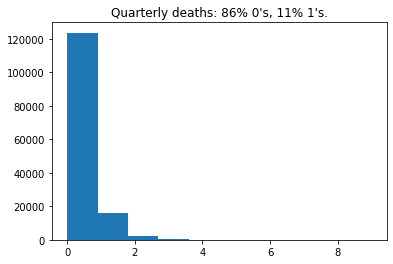

In [13]:
plt.hist(deaths_gdf['deaths'], bins=10)
plt.title("Quarterly deaths: 86% 0's, 11% 1's.")

In [12]:
 1.61790e+04/len(deaths_gdf)

0.11348905723905724

Text(0.5, 1.0, "Annual Deaths: 61.93% 0's, 24.06% 1's")

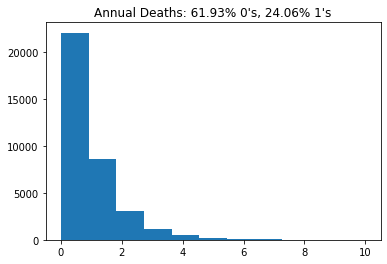

In [30]:
counts,_,_ = plt.hist(deaths_gdf.groupby(level=[0,1]).sum()['deaths'], bins=11)
plt.title(f"Annual Deaths: {counts[0]/sum(counts)*100:.2f}% 0's, {counts[1]/sum(counts)*100:.2f}% 1's")